In [5]:
#import libraries
import copy
import bokeh
from bokeh.plotting import show

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import flowkit as fk ## Library for all the Flow data processing, has good documentation
import glob as glob
import math

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

Loading BokehJS ...

In [6]:
list = np.sort(glob.glob("/Users/calebmcgrath/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Research/Ram Data/Geometric mean calculations/Quenching DIP50H50_Cell Uptake_12/*.fcs"))

In [26]:
## defining functions

def get_file_name(file_path):
    """Given a file path this function finds the file name"""
    file_path_components = file_path.split('/')
    file_name_and_extension = file_path_components[-1].rsplit('.', 1)
    returned = file_name_and_extension[0]
    final_file_name = returned.split('\\')[-2] + ' - ' +returned.split('\\')[-1]
    return final_file_name

def geometric_mean(arr):
    """This function calculates the geometric mean of a array, utilizing logarithm rules 
    to minimize the computational size"""
    n = len(arr)
    log_sum = 0
    N = len(arr)
    count = 0

    
    for num in arr:
        if num <= 0:
            count +=1
        else:
            log_sum += math.log(num)

    n = len(arr)-count 
    
    return (math.exp(log_sum / n)),count, N

def gated_cells (fcs_df, cell_gate_membership_array):
    """This function allows takes in a binary array for cell membership to a gate, along
    with the original dataframe from all the gates cells, and outputs a datafram that only
    include the values relavent to the cells containted within that gate"""

    #intializes column title array as well as the array to store filtered values
    titles = fcs_df.columns.values
    array_for_df = []

    #loops through titles filtering for cells that are contained within the gate
    for i in titles:
        array = fcs_df[i]
        new_array = []
        for i in range(len(array)):
            if cell_gate_membership_array[i]:
                new_array.append(array[i])

        array_for_df.append(new_array)

    #intializing dictionary to create data frame from
    d = {}

    #matching data with titles in dictionary for dataframe creation
    for i in range(len(titles)):
        d[titles[i]]= array_for_df[i]

    #creating dataframe
    df = pd.DataFrame(d)
    
    return df

In [8]:
def geo_mean_master_function(path_list):
    
    file_names = []
    geometric_means = []
    number_of_exclusions = []
    num_cells = []
    percent_excluded = []
    
    for i in range(len(path_list)):
        
        path_list_sorted = np.sort(path_list)
        fcs_path = path_list_sorted[i]
        file_name = get_file_name(fcs_path)
        
        sample = fk.Sample(fcs_path)
        df_events = sample.as_dataframe(source='raw')
        
        g_strat = fk.GatingStrategy()
        
        dim_SSC = fk.Dimension('SSC-A')
        dim_FSC = fk.Dimension('FSC-A')

        vertices = [
            (1200000,400000),
            (2400000,500000),
            (2800000,1000000),
            (3000000,2000000),
            (2600000,2500000),
            (1800000,2800000),
            (1200000,2800000),
            (670000,2200000),
            (470000,1800000),
            (505000,1000000)
        ]

        poly_gate = fk.gates.PolygonGate(
            'Cells', 
            dimensions=[dim_FSC, dim_SSC],
            vertices=vertices
        )

        g_strat.add_gate(poly_gate, gate_path=('root',))
        res = g_strat.gate_sample(sample)

        dim_SSC_A = fk.Dimension('SSC-A')
        dim_SSC_H = fk.Dimension('SSC-H')

        center = (1500000, 700000)
        cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
        dist = 1000000

        ellipse_gate = fk.gates.EllipsoidGate(
            'Singlet', 
            dimensions=[dim_SSC_A, dim_SSC_H], 
            coordinates=center,
            covariance_matrix=cov,
            distance_square=dist
        )

        g_strat.add_gate(ellipse_gate, gate_path=('root','Cells',))
        res = g_strat.gate_sample(sample)
        
        sample_gate = g_strat.gate_sample(sample)
        sample_singlet_gated = sample_gate.get_gate_membership('Singlet')
        
        gated_cel = gated_cells(df_events,sample_singlet_gated)
        
        geometric_mean_calc, number_of_exclusion, num_cell = geometric_mean(gated_cel['R2-A'])
        
        file_names.append(file_name)
        geometric_means.append(np.round(geometric_mean_calc,4))
        number_of_exclusions.append(number_of_exclusion)
        num_cells.append(num_cell)
        percent_excluded.append(np.round(((number_of_exclusion/num_cell)*100),4))
    
    
    dict_df = {'Sample Name' : file_names,'Geometric Mean' : geometric_means, 'Number of Exclusions' : number_of_exclusions, 'Number of Cells' : num_cells
              , 'Percent Excluded' : percent_excluded}
    geo_mean_df = pd.DataFrame(dict_df)
    
    return geo_mean_df

In [9]:
path = "/Users/calebmcgrath/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Research/Ram Data/Geometric mean calculations/Quenching DIP50H50_Cell Uptake_12/*.fcs"

files = np.sort(glob.glob(path))
fcs_path = files[0]
sample = fk.Sample(fcs_path)

In [10]:
df_events = sample.as_dataframe(source='raw')

f = sample.plot_scatter('FSC-A', 'SSC-A', source='raw')
show(f)

In [11]:
g_strat = fk.GatingStrategy()

In [12]:
dim_SSC = fk.Dimension('SSC-A')
dim_FSC = fk.Dimension('FSC-A')

# Changing
vertices = [
    (1200000,400000),
    (2400000,500000),
    (2800000,1000000),
    (3000000,2000000),
    (2600000,2500000),
    (1800000,2800000),
    (1200000,2800000),
    (670000,2200000),
    (470000,1800000),
    (505000,1000000)
]

poly_gate = fk.gates.PolygonGate(
    'Cells', 
    dimensions=[dim_FSC, dim_SSC],
    vertices=vertices
)

g_strat.add_gate(poly_gate, gate_path=('root',))
res = g_strat.gate_sample(sample)
res

In [13]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Cells')

p = sample.plot_scatter(
    'FSC-A', 'SSC-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [14]:
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw',subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(f)

In [15]:
dim_SSC_A = fk.Dimension('SSC-A')
dim_SSC_H = fk.Dimension('SSC-H')

center = (1500000, 700000)
cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
dist = 1000000

ellipse_gate = fk.gates.EllipsoidGate(
    'Singlet', 
    dimensions=[dim_SSC_A, dim_SSC_H], 
    coordinates=center,
    covariance_matrix=cov,
    distance_square=dist
)

g_strat.add_gate(ellipse_gate, gate_path=('root','Cells',))
res = g_strat.gate_sample(sample)

In [16]:
sample_gate = g_strat.gate_sample(sample)
sample_singlet_gated = sample_gate.get_gate_membership('Singlet')

In [17]:
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw',subsample=False, color_density = True, highlight_indices=sample_singlet_gated)
show(f)

In [18]:
gated_cel = gated_cells(df_events,sample_singlet_gated)

In [19]:
gated_cel['R2-A']

0      -147.416245
1       306.375000
2        55.005001
3       -40.398750
4      -669.322510
           ...    
3982   -374.774994
3983   -339.720001
3984     25.792500
3985    253.578751
3986   -217.169998
Name: R2-A, Length: 3987, dtype: float64

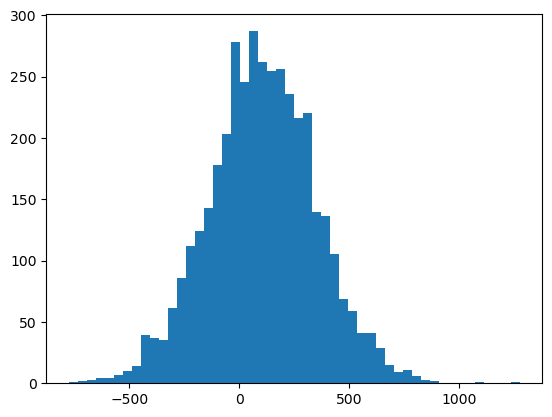

In [20]:
plt.hist(gated_cel['R2-A'],bins=50)
plt.show()

In [21]:
count = 0

for i in gated_cel['R2-A']:
    if i <= 0:
        count += 1

In [22]:
count

1312

In [20]:
geometric_mean(gated_cel['R2-A'])

(30.819343819758156, 1312, 3987)

In [23]:
counter = 0

for i in gated_cel['R2-A']:
    if i <= 0:
        counter += 1
        
counter

1312

In [24]:
f = sample.plot_scatter('SSC-A', 'R2-A', source='raw',subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(f)

In [23]:
geo_means = geo_mean_master_function(list)

In [24]:
display(geo_means)

,Sample Name,Geometric Mean,Number of Exclusions,Number of Cells,Percent Excluded
0,Group_001 - A1 Untreated _001,30.8193,1312,3987,32.9069
1,Group_001 - A2 Untreated _002,28.9495,466,1370,34.0146
2,Group_001 - A3 Untreated _003,32.2732,618,1918,32.2211
3,Group_001 - A4 Q-0_001,87711.7357,1,1600,0.0625
4,Group_001 - A5 Q-0_002,75597.2223,2,5861,0.0341
5,Group_001 - A6 Q-0_003,67960.5446,2,5933,0.0337
6,Group_001 - A7 Q-60_001,34404.2686,5,4867,0.1027
7,Group_001 - A8 UT-2_001,30.3154,17921,55055,32.5511
8,Group_001 - B1 Water +pDNA_001,3139.6405,1,50,2.0000
9,Group_001 - B2 Water +pDNA_002,6832.3220,7,9641,0.0726


In [25]:
geo_means.to_csv('/Users/calebmcgrath/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Research/Ram Data/Geometric mean calculations/Quenching DIP50H50_Cell Uptake_1 Geometric Means.csv', index=False)

In [95]:
# Save as PNG
fig, ax = plt.subplots(figsize=(18, 12))  # Adjust the figsize if needed
ax.axis('off')
ax.table(cellText=geo_means.values, colLabels=geo_means.columns, loc='center')
plt.savefig('/Users/calebmcgrath/Library/CloudStorage/OneDrive-ColoradoSchoolofMines/Research/Ram Data/Geometric mean calculations/Quenching DIP50H50_Cell Uptake_1 Geometric Means.png',
            bbox_inches='tight', pad_inches=0.2, dpi=600)